## Testing on Data

In [1]:
import time
from dotenv import load_dotenv

from typing import List, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END

from IPython.display import display, Markdown, Image


from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
)

import pandas as pd

from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score


In [2]:
MODEL = "google_genai:gemini-2.5-flash-preview-05-20"  # 
MODEL_2 = "openai:gpt-4o"
MODEL_3 = "google_genai:gemini-2.0-flash-001"

In [3]:
model_dict = {
    "example_generator_model": MODEL,
    "example_selector_model": MODEL_2,
    "classifier_model": MODEL,
}

In [4]:
load_dotenv("../.env")

True

In [5]:
# Train Data N Shot Selector

from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = FAISS.load_local(
    # "./faiss_indices/core_data_index", 
    "./faiss_indices/semeval_data_index",
    embedding_model, allow_dangerous_deserialization=True
    
)

def retrieve_similar_rows(vector_store, query, k=2):
    docs_and_scores = vector_store.similarity_search_with_score(query, k=k)
    output = []
    for doc, score in docs_and_scores:
        metadata = doc.metadata
        metadata["label"] = metadata["relation"]
        metadata["context"] = metadata["sentence"]
        output.append(metadata)
    return output

# Example usage
# query_example = df.iloc[0]['sentence']
# similar_contexts = retrieve_similar_rows(vector_store,query_example)
# print(f"Query: {query_example}\n")
# print("Similar contexts:")
# for context in similar_contexts:
#     print(f"Context: {context}\n")

In [6]:
df = pd.read_csv("../datasets/refind_data/final_test.csv")
df = df.sample(1000, random_state=42).reset_index(drop=True)
print(df.shape)
df.head()

(1000, 4)


sentence  \
0  The plaintiffs also alleged that the defendant...   
1  STARRETT L S CO s manufacturing operations are...   
2  From 1963 - 1964 , Mr. Cassidy was law clerk t...   
3  Finally , COMTECH TELECOMMUNICATIONS CORP /DE/...   
4  In November 2008 , Cytosorbents Corp changed t...   

                          entity_1                     entity_2  \
0                       Parliament  Bravo Multinational Inc. 's   
1                STARRETT L S CO s                        China   
2                   Inzer B. Wyatt                        clerk   
3  COMTECH TELECOMMUNICATIONS CORP                        13.43   
4                Cytosorbents Corp          CytoSorbents , Inc.   

                relation  
0            no_relation  
1  org:gpe:operations_in  
2            no_relation  
3            no_relation  
4            no_relation

In [7]:
all_relations = df['relation'].unique().tolist()
print(all_relations)

['no_relation', 'org:gpe:operations_in', 'pers:title:title', 'org:org:acquired_by', 'org:gpe:formed_in', 'org:money:cost_of', 'org:date:formed_on', 'org:org:shares_of', 'pers:univ:employee_of', 'org:org:agreement_with', 'pers:org:employee_of', 'pers:org:member_of', 'org:org:subsidiary_of', 'org:money:profit_of', 'org:money:revenue_of', 'org:money:loss_of', 'pers:univ:attended', 'org:gpe:headquartered_in', 'pers:org:founder_of', 'pers:univ:member_of', 'org:date:acquired_on']


In [8]:
# structured output Data Models
class SelectedLabels(BaseModel):
    labels: List["str"]  # add something to limit number of selected labels, check later

class GeneratedPositiveExample(BaseModel):
    context: str
    entity_1: str
    entity_2: str
    label: Literal[*all_relations]
    explanation: str
    is_generated : bool = Field(description="Indicates if the example was generated by a model")

class GeneratedPositiveExamples(BaseModel):
    examples: List[GeneratedPositiveExample]

class GeneratedNegativeExample(BaseModel):
    context: str
    entity_1: str
    entity_2: str
    label: str = Field(description="Incorrectly Predicted label")
    explanation : str = Field(description="Explanation why predicted label is not correct")
    correct_label : str = Field(description="Correct label")
    is_generated : bool = Field(description="Indicates if the example was generated by a model")

class GeneratedNegativeExamples(BaseModel):
    examples: List[GeneratedNegativeExample]

class FinalSelectedExamples(BaseModel):
    positive_examples: List[GeneratedPositiveExample]
    negative_examples: List[GeneratedNegativeExample]

class EvaluateRelationshipOutput(BaseModel):
    output: Literal[*all_relations]
    explanation: str = Field(default="Explanation for choosing the label")

In [9]:
# state for input
class InputState(TypedDict):
    context : str
    entity_1 : str
    entity_2 : str
    list_of_labels : List[str]
    # selected_labels : SelectedLabels
    n_selected_train_examples : int
    n_positive_examples_to_generate : int
    n_negative_examples_to_generate : int
    train_selected_examples : List
    negative_examples : List
    positive_examples : List
    final_num_examples_for_prompt : int
    final_selected_examples : dict
    label : str
    explanation : str

In [10]:
label_direction_related_info = "Relation org:gpe:operations_in means first entity is an organization and second entity is a country or city where the organization operates. Similarly for other relations." 

In [11]:
def select_helpful_labels_for_n_shot(state: InputState):
    llm = init_chat_model(
        model=model_dict["classifier_model"],
        temperature=0.2
    ).with_structured_output(SelectedLabels)

    out = llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant. You will be given a text with entities and a list of labels. Select labels from the list of labels. Selected labels should be such that generated positive and negative examples using these labels will be useful in doing N Shot Classification. {label_direction_related_info} In short, the model will be able to get confused between these selected labels while answering. Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['list_of_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    return {
        "selected_labels": out.labels
    }

def train_data_examples(state: InputState):
    similar_contexts = retrieve_similar_rows(
        vector_store, state['context'],
        k=state['n_selected_train_examples']
    )
    return {
        "train_selected_examples": similar_contexts
    }


def generate_positive_example(state: InputState):
    """Generate a positive example for the given text, entities and label."""
    positive_example_llm = init_chat_model(
        model=model_dict["example_generator_model"],
        temperature=0.4,
    ).with_structured_output(GeneratedPositiveExamples)

    out = positive_example_llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that generates examples for relationship classification task. You will be given a text with entities and a list of labels. Generate distinct helpful and informative positive examples. Do not use exact context or entities in generated examples. {label_direction_related_info} Generate {state['n_negative_examples_to_generate']} examples. Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['list_of_labels']}\n\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    out = out.model_dump()
    return {
        "positive_examples": out["examples"]
    }


def generate_negative_example(state: InputState):
    """Generate a negative example for the given text, entities and label."""
    negative_example_llm = init_chat_model(
        model=model_dict["example_generator_model"],
        temperature=0.4,
    ).with_structured_output(GeneratedNegativeExamples)

    out = negative_example_llm.invoke(
        [
            SystemMessage(
                content=f"You are a evil assistant that generates examples for relationship classification task. You will be given a text with entities and a list of labels. Generate distinct helful and informative negative examples that help the model to understand why predicted label is incorrect and what is the correct label. Do not use the exact context or entities in generated examples. {label_direction_related_info} Generate {state['n_negative_examples_to_generate']} examples. Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['list_of_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    out = out.model_dump()
    
    return {
        "negative_examples": out["examples"]
    }

In [12]:
def format_positive_examples(positive_examples):
        prompt = ""
        for i, ex in enumerate(positive_examples, 1):
            prompt += (
                f"Example {i}:\n"
                f"  Context: {ex['context']}\n"
                f"  Entity 1: {ex['entity_1']}\n"
                f"  Entity 2: {ex['entity_2']}\n"
                f"  Label: {ex['label']}\n"
                f"  Explanation: {ex['explanation']}\n\n"
            )
        return prompt

def format_negative_examples(negative_examples):
    prompt = ""
    for i, ex in enumerate(negative_examples, 1):
        prompt += (
            f"Example {i}:\n"
            f"  Context: {ex['context']}\n"
            f"  Entity 1: {ex['entity_1']}\n"
            f"  Entity 2: {ex['entity_2']}\n"
            f"  Label: {ex['label']}\n"
            f"  Explanation: {ex['explanation']}\n"
            f"  Correct Label: {ex['correct_label']}\n\n"
        )
    return prompt


In [13]:
def select_final_examples(state: InputState):
    """Select final examples from the generated positive and negative examples."""
    final_examples_llm = init_chat_model(
        model=model_dict["example_selector_model"],
        temperature=0.4,
    ).with_structured_output(FinalSelectedExamples)

    postive_examples_string = format_positive_examples(state['positive_examples'])
    negative_examples_string = format_negative_examples(state['negative_examples'])
    
    training_examples_string = ""
    for i, ex in enumerate(state["train_selected_examples"], 1):
        training_examples_string += (
            f"Example {i}:\n"
            f"  Context: {ex['context']}\n"
            f"  Entity 1: {ex['entity_1']}\n"
            f"  Entity 2: {ex['entity_2']}\n"
            f"  Label: {ex['label']}\n\n"
        )

    out = final_examples_llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that selects final examples for N Shot relationship classification task. You will be given a context with entities, a list of labels, and selected examples from training data with generated positive and negative examples. Select the examples that will be helpful in identifying the label of the context for the entities in a N Shot setting. From all the provided examples strictly select a combined number of {state['final_num_examples_for_prompt']}, which are relevant, have clarity and have label diversity with contrast. {label_direction_related_info} Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"All Labels: {state['list_of_labels']}\n\n Context: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}\n\n Generated Positive Examples: {postive_examples_string}\n\n Generated Negative Examples: {negative_examples_string}\n\n Examples selected from training data: {training_examples_string}\n\n"
            )
        ]
    )
    out = out.model_dump()
    
    return {
        "final_selected_examples": out
    }

In [14]:
def evaluate_relationship(state: InputState):
    """Evaluate the relationship between the head and tail entities in the text."""
    relationship_evaluator = init_chat_model(
        model=model_dict["classifier_model"],
        temperature=0,
    ).with_structured_output(EvaluateRelationshipOutput)
    
    postive_examples_string = format_positive_examples(
        state['final_selected_examples']['positive_examples']
        if 'positive_examples' in state['final_selected_examples'] else []
    )
    negative_examples_string = format_negative_examples(
        state['final_selected_examples']['negative_examples']
        if 'negative_examples' in state['final_selected_examples'] else []
    )

    out = relationship_evaluator.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that identifies the relationship between two entities given a context. You will be given a context, and a pair of entities and a list of possible labels. You will also be given positive examples and negative examples for each similar labels for better understanding. Provide the answer in a JSON format. The output should be the label that best describes the relationship between the entities in the context. {label_direction_related_info}"
            ),
            HumanMessage(
                content=f"List of Labels: \n {state['list_of_labels']} \n\n\n\n Generated Positive Examples: {postive_examples_string}\n\n Generated Negative Examples: {negative_examples_string}\n\n Context: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            ),
        ]
    )
    
    return {
        "label": out.output,
        "explanation": out.explanation
    }

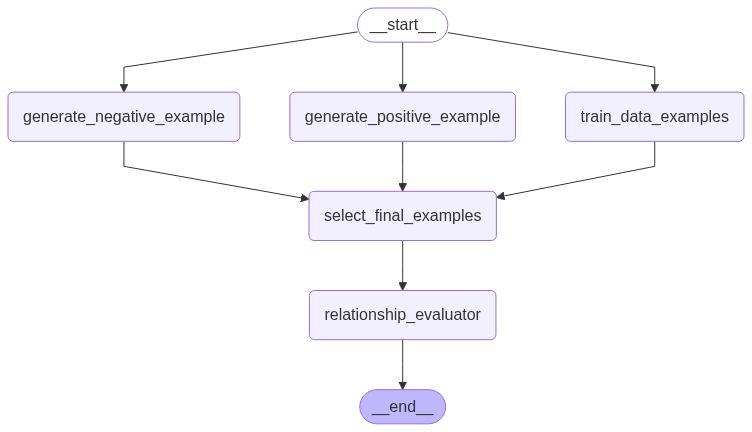

In [15]:
graph_builder = StateGraph(InputState)

# graph_builder.add_node("select_helpful_labels_for_n_shot", select_helpful_labels_for_n_shot)
graph_builder.add_node("generate_positive_example", generate_positive_example)  
graph_builder.add_node("generate_negative_example", generate_negative_example)
graph_builder.add_node("train_data_examples", train_data_examples)
graph_builder.add_node("select_final_examples", select_final_examples)
graph_builder.add_node("relationship_evaluator", evaluate_relationship)

# graph_builder.add_edge(START, "select_helpful_labels_for_n_shot")
graph_builder.add_edge(START, "generate_positive_example")
graph_builder.add_edge(START, "generate_negative_example")
graph_builder.add_edge(START, "train_data_examples")

graph_builder.add_edge(
    [
        "generate_positive_example", "generate_negative_example",
        "train_data_examples"
    ],
    "select_final_examples",
)
graph_builder.add_edge("select_final_examples", "relationship_evaluator")
graph_builder.add_edge("relationship_evaluator", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
%%time
input_data = {
    "context": df.iloc[2]['sentence'],
    "entity_1":df.iloc[2]['entity_1'],
    "entity_2": df.iloc[2]['entity_2'],
    "list_of_labels": all_relations,
    "n_selected_train_examples" : 20,
    "n_positive_examples_to_generate" : 10,
    "n_negative_examples_to_generate" : 10,
    "final_num_examples_for_prompt": 10
}
result = graph.invoke(input_data)
result["label"]

Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=2686a756-69ab-4c1b-95ba-6fc6322cfe8d; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=6be2f8f7-05b1-4c41-92a9-d1865c2e1ec4; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=3ec5253c-1bd5-43e0-b3c8-b4e0fdf4e82c; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=d3e9fc01-06f6-465a-961f-2ca81c264327; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=a75a5851-107d-4a96-ad90-a5381f04d1b2; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=0c2c8239-994f-4c55-9b12-275d91ccc883
Failed to send compressed multipart ingest: langsmith.

CPU times: user 700 ms, sys: 130 ms, total: 831 ms
Wall time: 36.8 s


'no_relation'

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=1265f880-cddd-4d01-b4ec-f48473f3368f; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=1ac5888b-7004-4278-883f-7630f74bb1a2; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=1ac5888b-7004-4278-883f-7630f74bb1a2; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=3ee10d01-9c29-4056-8045-4acb75cf298e; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=bb063a4b-b4ca-4e5a-96d2-e816283fcba6; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=bb063a4b-b4ca-4e5a-96d2-e816283fcba6; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f,id=f95ddce1-a6e7-4a12-94c9-157bbeeea3ba; trace=19b3c51a-c5e3-48c0-bbf5-86ad15a3412f

In [17]:
result["label"]

'no_relation'

In [18]:
print(len(result["final_selected_examples"]["positive_examples"]), len(result["final_selected_examples"]["negative_examples"]))
print(sum([1 if ex['is_generated'] else 0 for ex in result["final_selected_examples"]["positive_examples"]]), sum([1 if ex['is_generated'] else 0 for ex in result["final_selected_examples"]["negative_examples"]]))

5 5
5 5


In [19]:
answers = {}

In [20]:
%%time
for row_id, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row_id not in answers:
        text = row['sentence']
        entity_1 = row['entity_1']
        entity_2 = row['entity_2']
        try : 
            input_data = {
                "context": text,
                "entity_1": entity_1,
                "entity_2": entity_2,
                "list_of_labels": all_relations,
                "n_selected_train_examples" : 20,
                "n_positive_examples_to_generate" : 10,
                "n_negative_examples_to_generate" : 10,
                "final_num_examples_for_prompt": 10
            }
            
            result = graph.invoke(input_data)
            
            answers[row_id] = result["label"]
            # time.sleep(2)
        except Exception as e:
            print(f"Error processing row {row_id}: {e}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 33: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 106: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 139: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 158: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised DeadlineExceeded: 504 Deadline Exceeded.


Error processing row 175: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 313: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 315: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 334: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 377: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 382: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 424: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 445: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 461: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 483: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised DeadlineExceeded: 504 Deadline Exceeded.


Error processing row 514: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 542: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 573: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Error processing row 606: 'NoneType' object has no attribute 'output'


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 612: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 705: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 727: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 729: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 749: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 776: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 837: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 841: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 842: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 865: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 901: 504 Deadline Exceeded


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Error processing row 979: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
CPU times: user 6min 51s, sys: 1min 56s, total: 8min 47s
Wall time: 16h 33min 43s


In [21]:
len(answers)

970

In [19]:
# import asyncio
# import nest_asyncio
# nest_asyncio.apply()

# async def call_graph(input_dict, all_relations):
#     try : 
#         input_data = {
#             "context": input_dict['sentence'],
#             "entity_1": input_dict["entity_1"],
#             "entity_2": input_dict["entity_2"],
#             "list_of_labels": all_relations,
#             "n_selected_train_examples" : 20,
#             "n_positive_examples_to_generate" : 10,
#             "n_negative_examples_to_generate" : 10,
#             "final_num_examples_for_prompt": 10
#         }
#         result = graph.invoke(input_data)
#         time.sleep(2)
#         return result
#     except Exception as e:
#         print(f"Error processing: {e}")
#         return None


# async def run_prediction(
#     input_df, all_relations
# ):
#     # iterate asynchronouly over the test dataframe
#     tasks = [Wolves
#         call_graph(
#             input_dict=row.to_dict(),
#             all_relations=all_relations
#         )
#         for _, row in tqdm(input_df.iterrows(), total=input_df.shape[0], desc="Processing rows")
#     ]
#     all_graph_outputs = await asyncio.gather(*tasks)
#     all_graph_outputs = [
#         graph_output["label"] if graph_output is not None else None 
#         for graph_output in all_graph_outputs
#     ]
#     return all_graph_outputs

# import asyncio
# from tqdm.notebook import tqdm

# async def run_prediction(input_df, all_relations):
#     tasks = [
#         call_graph(
#             input_dict=row.to_dict(),
#             all_relations=all_relations
#         )
#         for _, row in input_df.iterrows()
#     ]
#     results = []
#     with tqdm(total=len(tasks), desc="Processing rows") as pbar:
#         for coro in asyncio.as_completed(tasks):
#             result = await coro
#             results.append(result)
#             pbar.update(1)
#     all_graph_outputs = [
#         graph_output["label"] if graph_output is not None else None 
#         for graph_output in results
#     ]
#     return all_graph_outputs


# temp_df = df.sample(100, random_state=42).reset_index(drop=True)
# temp_df.shape

# %%time
# all_api_outputs = asyncio.run(
#     run_prediction(
#         input_df=temp_df,
#         all_relations=all_relations
#     )
# )
# temp_df["predicted_label"] = all_api_outputs
# temp_df.dropna(subset=['predicted_label'], inplace=True)

# print(classification_report(temp_df.relation, temp_df.predicted_label, labels=all_relations))

In [22]:
df['predicted_label'] = df.index.map(answers)

In [23]:
df.isnull().sum()

sentence            0
entity_1            0
entity_2            0
relation            0
predicted_label    30
dtype: int64

In [24]:
model_dict

{'example_generator_model': 'google_genai:gemini-2.5-flash-preview-05-20',
 'example_selector_model': 'openai:gpt-4o',
 'classifier_model': 'google_genai:gemini-2.5-flash-preview-05-20'}

In [25]:
df = df.dropna(subset=['predicted_label'])

In [26]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(df.relation, df.predicted_label, labels=all_relations))

                          precision    recall  f1-score   support

             no_relation       0.80      0.45      0.58       442
   org:gpe:operations_in       0.93      0.82      0.87       140
        pers:title:title       0.97      0.86      0.91       161
     org:org:acquired_by       0.09      0.67      0.16         3
       org:gpe:formed_in       0.00      0.00      0.00         2
       org:money:cost_of       0.12      1.00      0.22         2
      org:date:formed_on       0.86      0.86      0.86        22
       org:org:shares_of       0.15      0.60      0.24        10
   pers:univ:employee_of       0.00      0.00      0.00         2
  org:org:agreement_with       0.21      0.73      0.33        30
    pers:org:employee_of       0.62      0.89      0.74        84
      pers:org:member_of       0.14      0.10      0.11        21
   org:org:subsidiary_of       0.47      0.94      0.62        16
     org:money:profit_of       0.33      1.00      0.50         2
    org:m

/run/media/kuldeepsingh/Work/venv_environments/ai_agents_experiments/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/run/media/kuldeepsingh/Work/venv_environments/ai_agents_experiments/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/run/media/kuldeepsingh/Work/venv_environments/ai_agents_experiments/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

In [27]:
f1_score(df.relation, df.predicted_label, average='macro'), f1_score(df.relation, df.predicted_label, average='micro')

(0.4982487912585747, 0.6422680412371135)

In [90]:
model_dict

{'example_generator_model': 'google_genai:gemini-2.0-flash-001',
 'example_selector_model': 'openai:gpt-4o',
 'classifier_model': 'google_genai:gemini-2.5-flash-preview-05-20'}

In [28]:
df.to_csv("./../prediction_files/kuldeep/refind_pos_neg_agent_using_gemini_flash_25_as_gen_and_class_gpt_4o_selector_v2_model.csv", index=False)

In [ ]:
# df.to_csv("./../prediction_files/kuldeep/core_pos_neg_agent_using_gemini_flash_25_as_gen_classi_gpt_4o_selector_v2_model.csv", index=False)

In [ ]:
Large language models (LLMs) excel at general-purpose language understanding but often underperform on domain-specific relation extraction tasks due to the complexity and structure of relational semantics. We present ALIEN, a modular multi-agent framework designed specifically for relation extraction. ALIEN integrates three agent architectures that leverage complementary reasoning strategies: reflective self-critique, hierarchical task delegation, and a novel multi-agent dynamic example generation mechanism. While these techniques have been explored in isolation, ALIEN is the first to unify them in a domain-adaptive, relation-centric setting. In particular, our dynamic example generation approach introduces real-time cooperative and adversarial prompting, allowing agents to construct tailored few-shot contexts per instance. We evaluate ALIEN across financial, scientific, and general-domain datasets, showing consistent gains over few-shot prompting baselines and performance comparable to fine-tuned models. These results demonstrate ALIEN’s potential to improve accuracy, adaptability, and interpretability in low-resource and zero-shot environments.